In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from pprint import pprint
from scipy import signal
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from utils.plotting import *
from utils.processing import *
from model.configuration import ProcessConfig

# Workspace dirs
lfr_ws = 'Documents/workspaces/lfr/weighted_overlapping/networks'
lfr_ws = pjoin(os.environ['HOME'], lfr_ws)
svinet_dir = './svinet_results'

# svinet...


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
rng = np.random.RandomState(RANDOM_STATE)

In [2]:
from utils.processing import filter_boundaries

In [71]:
load_dir = '/home/hadi/Downloads'
ses1 = 'sub-SLC06_ses-1_space-individual_desc-fineatlas2d_ca2.nii.gz'
ses2 = 'sub-SLC06_ses-2_space-individual_desc-fineatlas2d_ca2.nii.gz'

img1 = nib.load(pjoin(load_dir, ses1))
img2 = nib.load(pjoin(load_dir, ses2))

a1 = img1.get_fdata()
a2 = img2.get_fdata()

b1 = a1.copy()
b2 = a2.copy()

for i, j in enumerate(np.unique(a1)):
    b1[b1==j] = i
for i, j in enumerate(np.unique(a2)):
    b2[b2==j] = i

# b1, b2 = tuple(map(filter_boundaries, [b1, b2]))
b1, b2 = tuple(map(lambda x: x.squeeze(), [b1, b2]))

b1[b1==0] = np.nan
b2[b2==0] = np.nan

In [72]:
a1.shape, a2.shape, b1.shape, b2.shape

((512, 500, 1), (512, 500, 1), (512, 500), (512, 500))

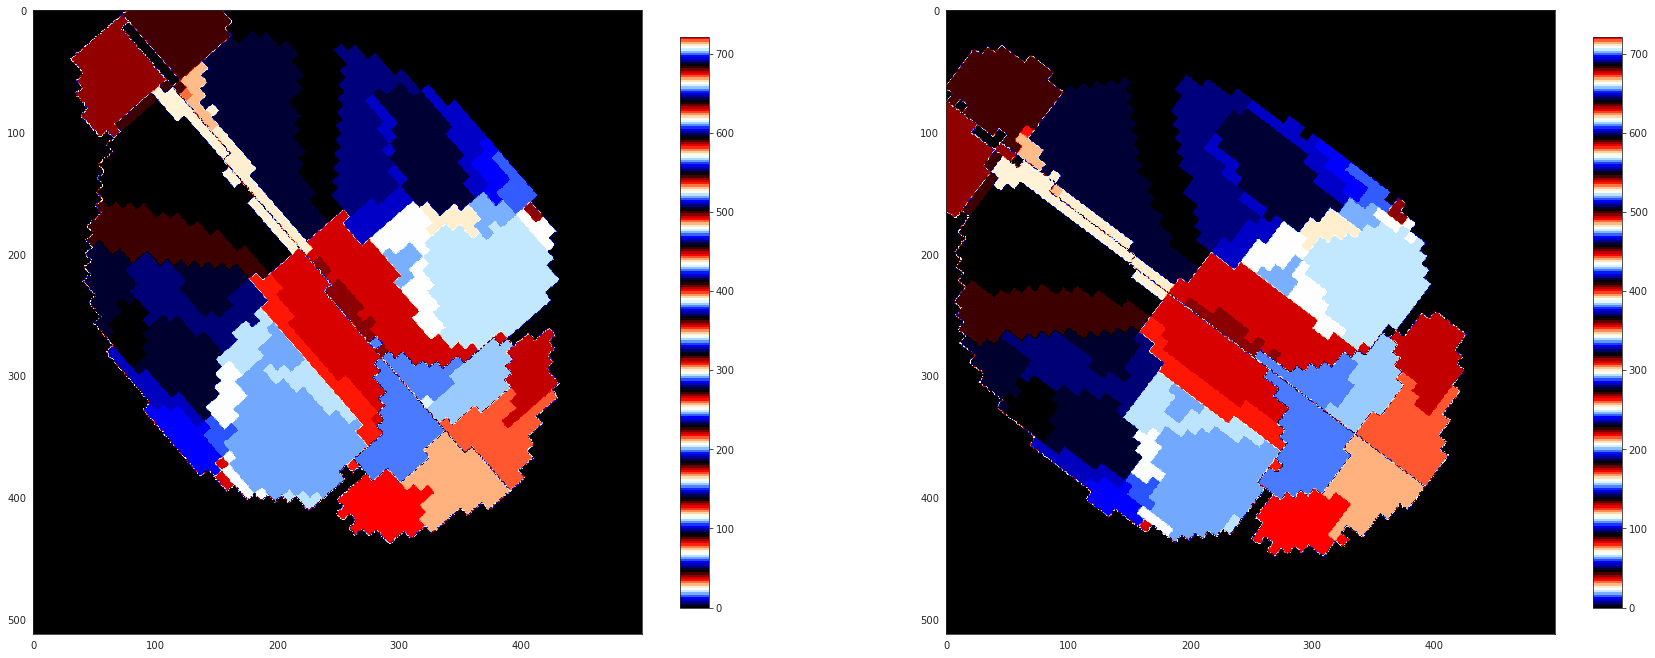

In [73]:
plt.figure(figsize=(30, 15))

plt.subplot(121)
plt.imshow(a1[..., 0], cmap='flag_r')
plt.colorbar(shrink=0.7)

plt.subplot(122)
plt.imshow(a2[..., 0], cmap='flag_r')
plt.colorbar(shrink=0.7)
plt.show()

In [74]:
np.unique(a1), np.unique(a2), len(np.unique(a1)), len(np.unique(a2))

(array([  0.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         14.,  15.,  16.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
         26.,  28.,  30.,  33.,  38.,  39.,  40.,  41.,  44., 154., 155.,
        156., 160., 215., 216., 221., 501., 502., 503., 504., 505., 506.,
        507., 508., 509., 510., 511., 514., 515., 516., 518., 519., 520.,
        521., 522., 523., 524., 525., 526., 528., 530., 538., 539., 540.,
        541., 544., 655., 656., 715., 716., 721., 722.]),
 array([  0.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         14.,  15.,  16.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
         26.,  28.,  30.,  34.,  38.,  39.,  40.,  41.,  44.,  45., 154.,
        155., 156., 157., 215., 216., 221., 222., 501., 502., 503., 504.,
        505., 506., 507., 508., 509., 510., 511., 514., 515., 516., 518.,
        519., 520., 521., 522., 523., 524., 525., 526., 528., 530., 538.,
        539., 540., 541., 544., 655., 656., 715., 716.

In [89]:
ses1

'sub-SLC06_ses-1_space-individual_desc-fineatlas2d_ca2.nii.gz'

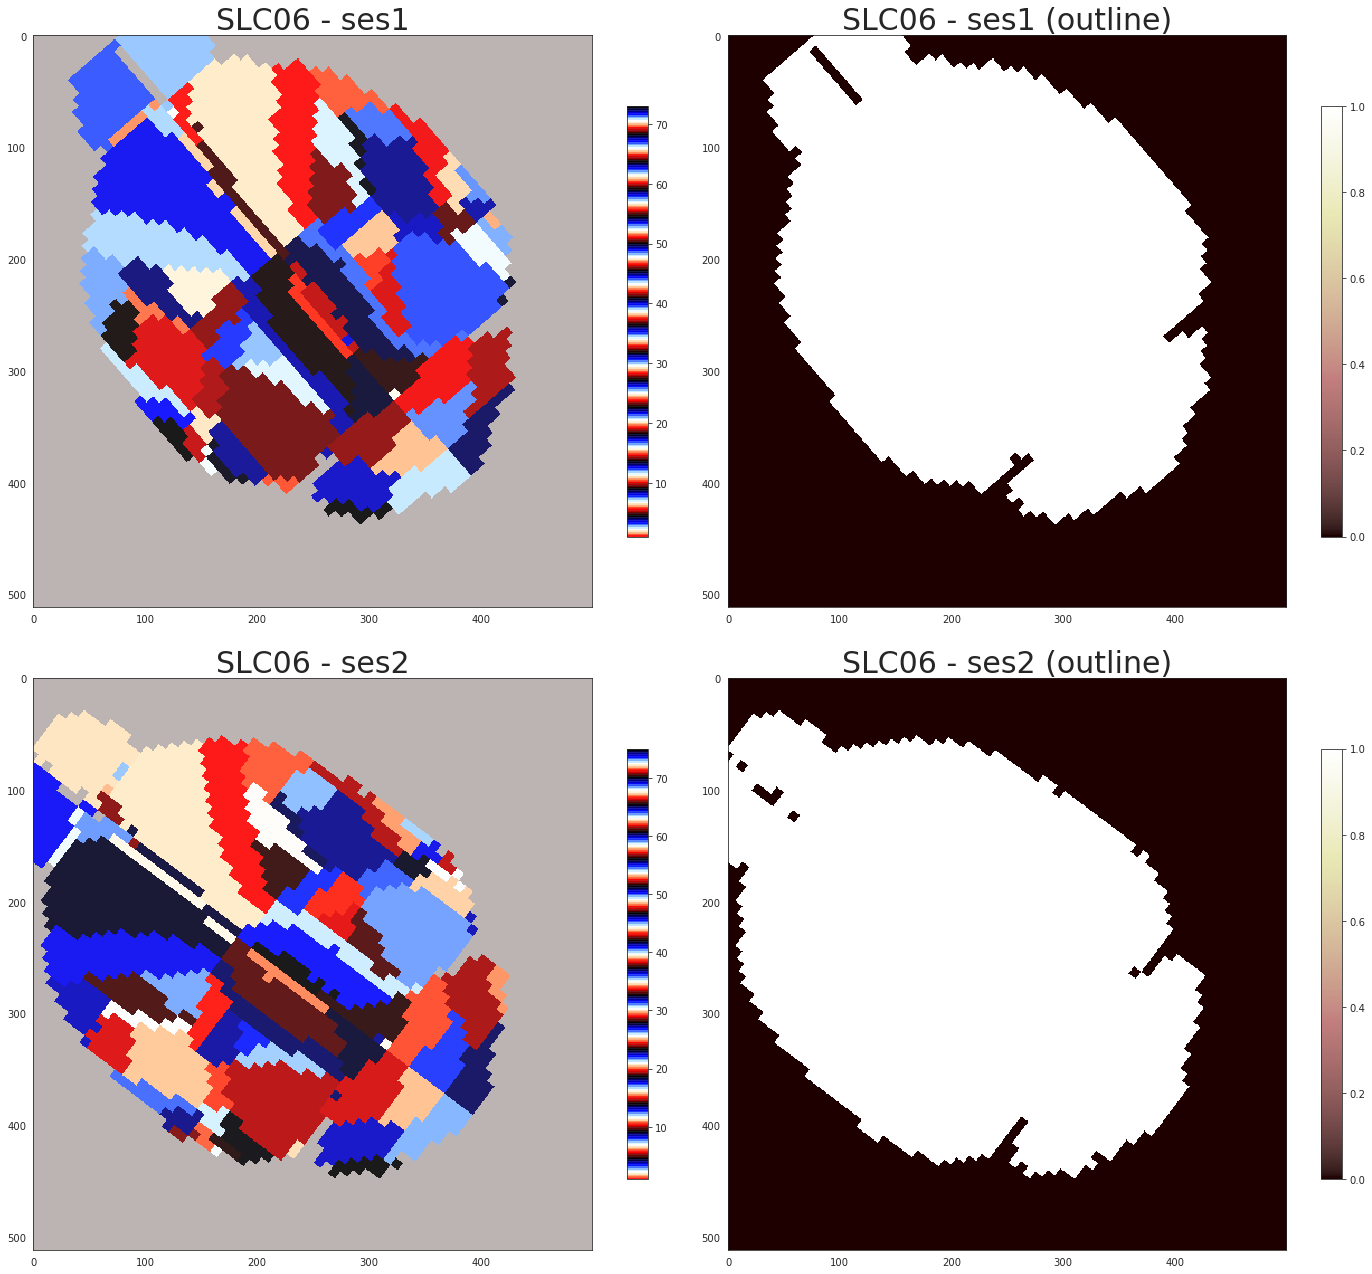

In [106]:
plt.figure(figsize=(20, 18))

plt.subplot(221)
plt.imshow(a1.squeeze()==0, cmap='pink_r', alpha=0.3, interpolation='none')
plt.imshow(b1, cmap='flag', alpha=0.9, interpolation='none')
plt.colorbar(shrink=0.7)
plt.title('SLC06 - ses1', fontsize=30)

plt.subplot(223)
plt.imshow(a2.squeeze()==0, cmap='pink_r', alpha=0.3, interpolation='none')
plt.imshow(b2, cmap='flag', alpha=0.9, interpolation='none')
plt.colorbar(shrink=0.7)
plt.title('SLC06 - ses2', fontsize=30)

plt.subplot(222)
plt.imshow(a1.squeeze()>0, cmap='pink', interpolation='none')
plt.colorbar(shrink=0.7)
plt.title('SLC06 - ses1 (outline)', fontsize=30)

plt.subplot(224)
plt.imshow(a2.squeeze()>0, cmap='pink', interpolation='none')
plt.colorbar(shrink=0.7)
plt.title('SLC06 - ses2 (outline)', fontsize=30)

plt.tight_layout()
plt.savefig('atlas.pdf', dpi=400, format='eps')
plt.show()

In [42]:
c1 = a1.copy().squeeze()
c2 = a2.copy().squeeze()

c1[c1==0] = np.nan
c2[c2==0] = np.nan

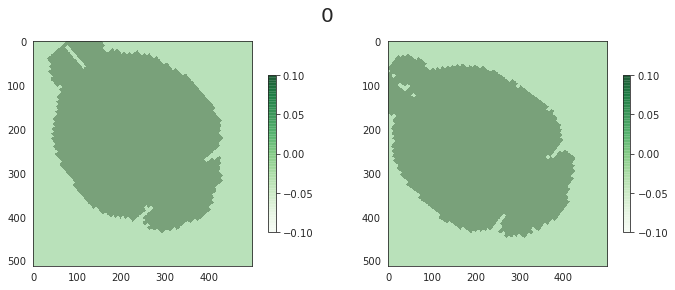

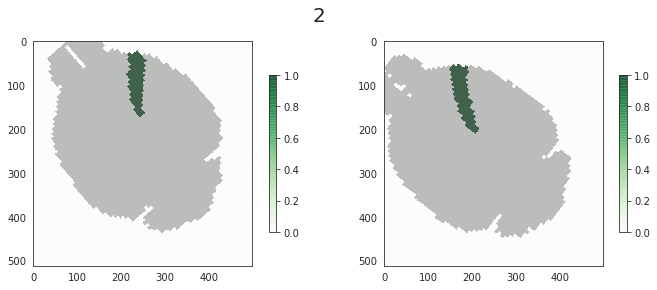

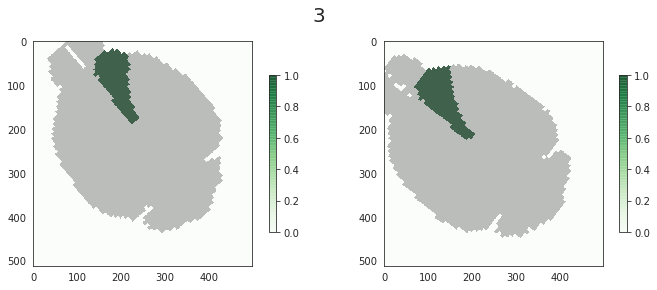

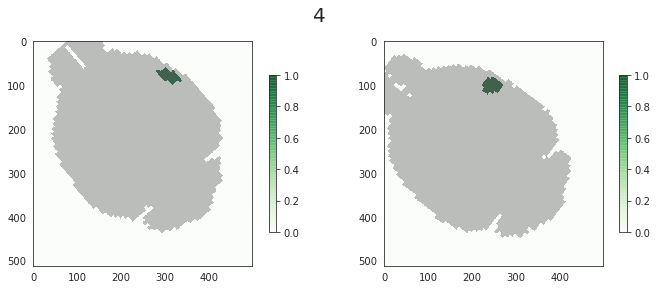

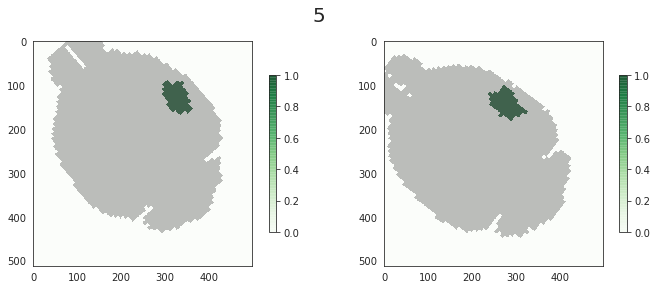

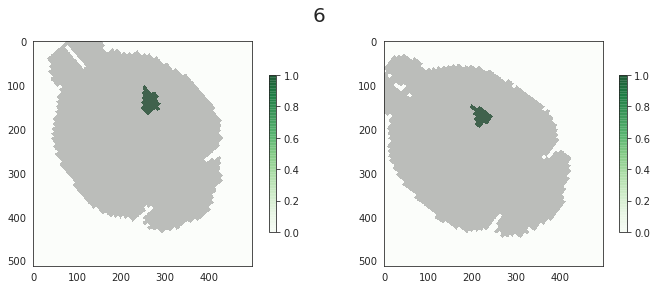

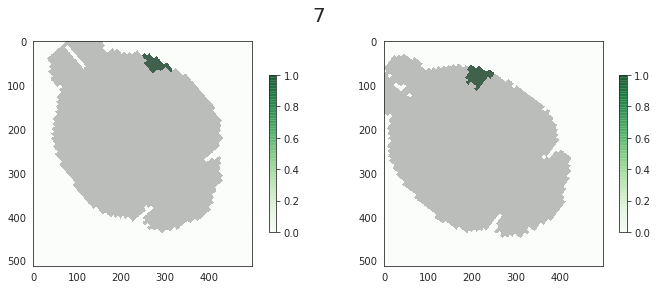

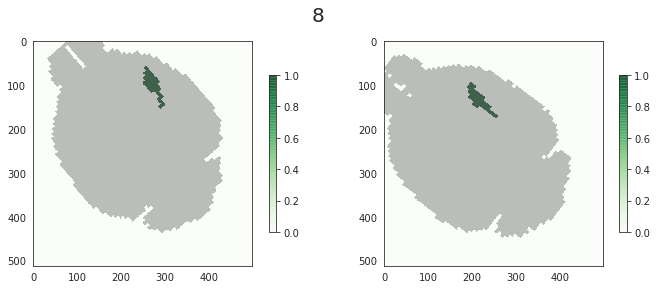

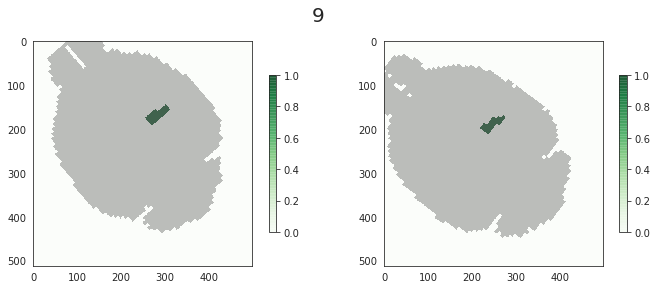

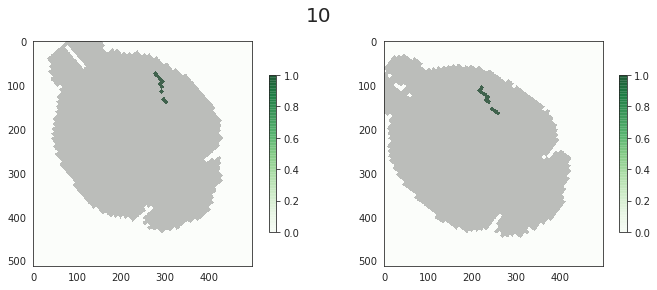

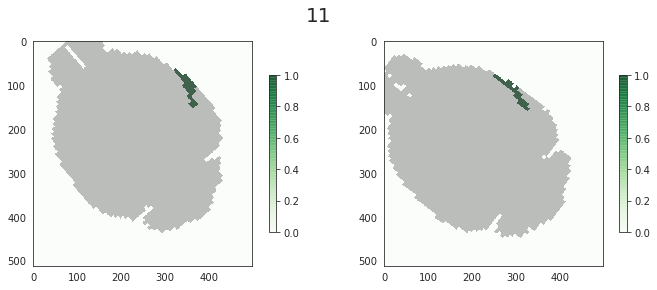

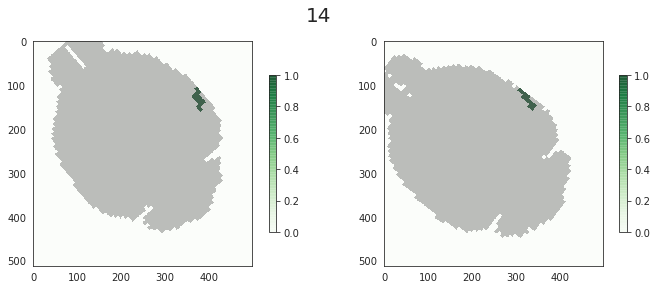

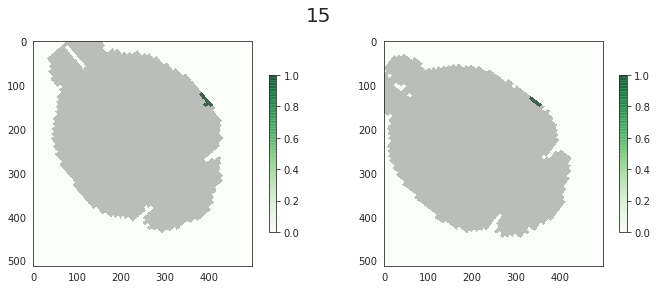

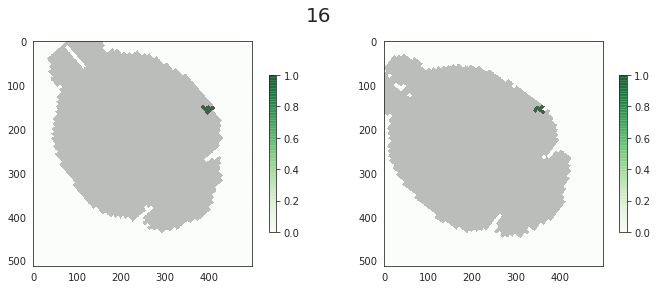

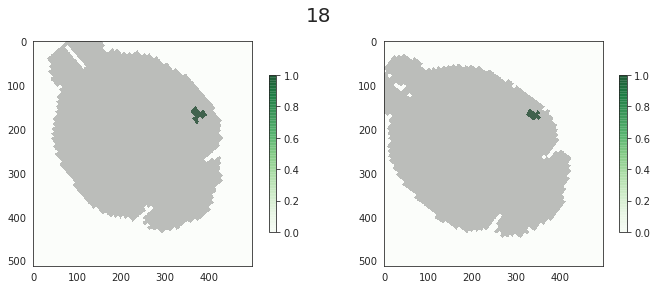

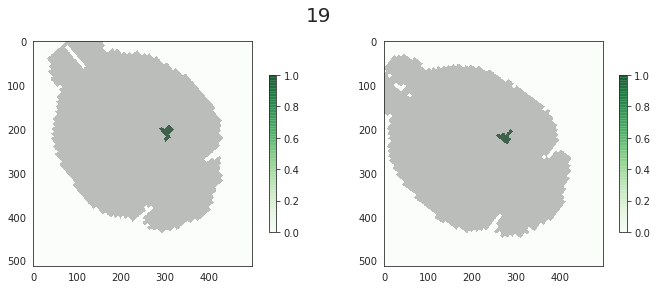

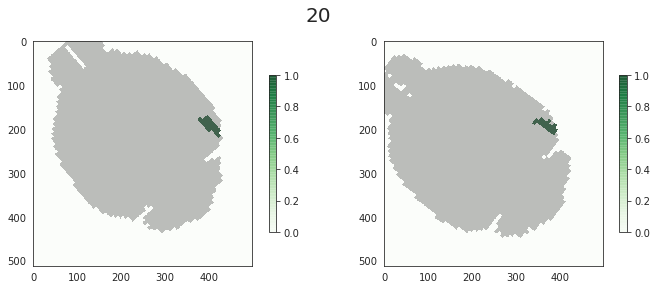

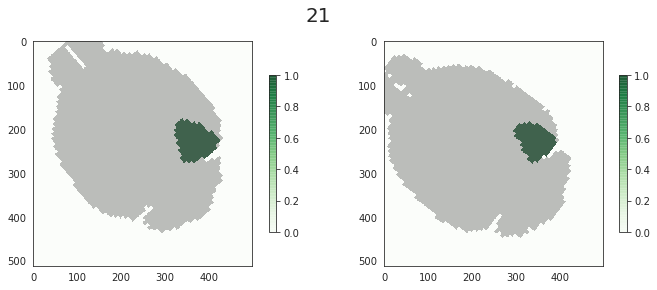

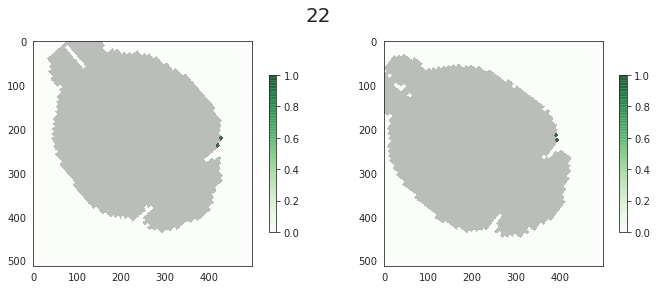

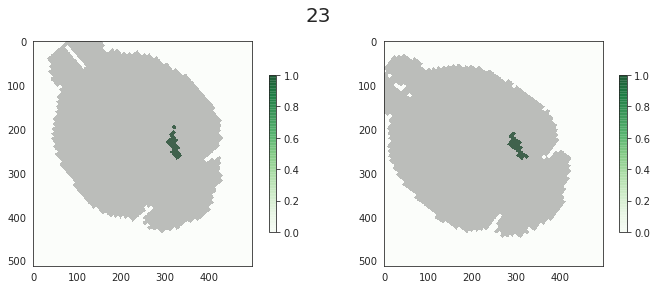

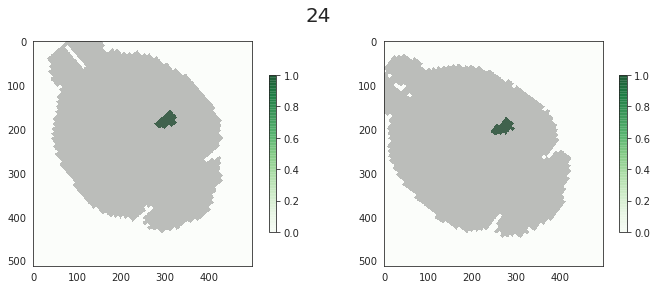

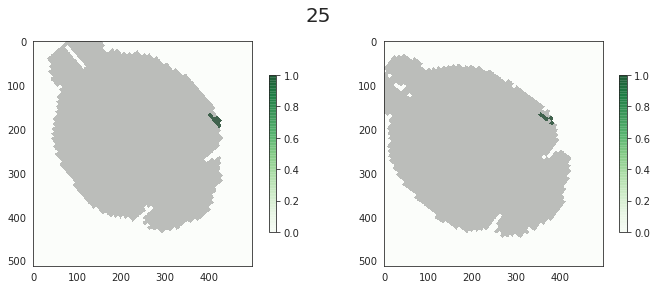

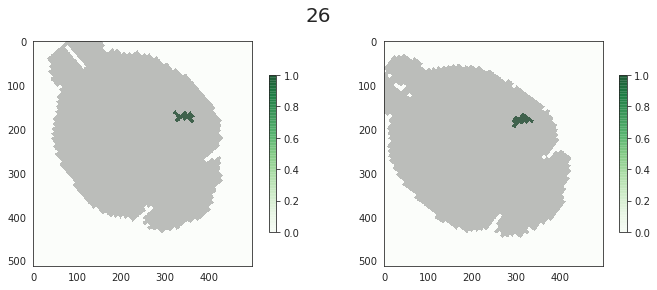

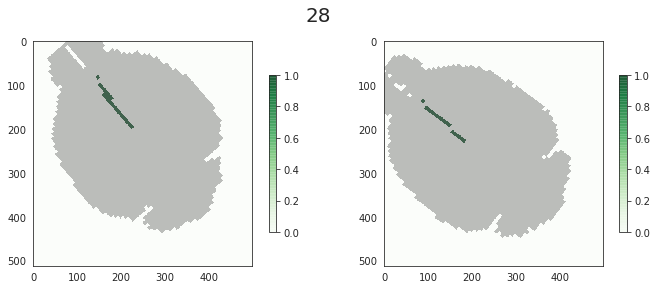

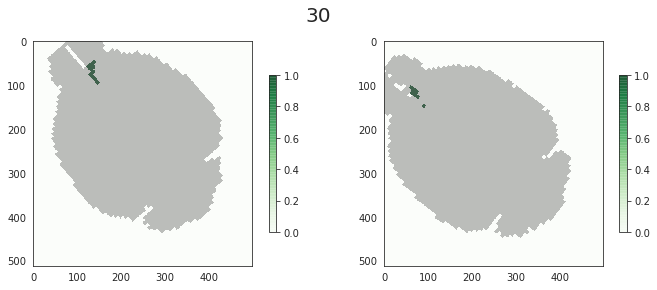

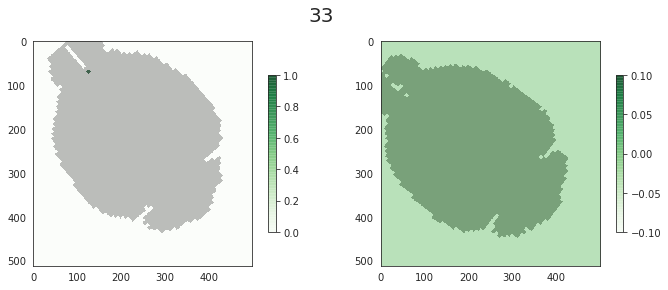

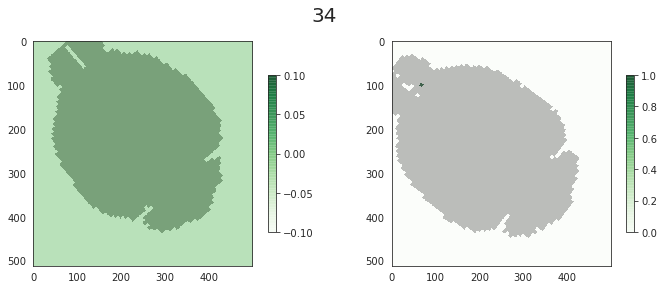

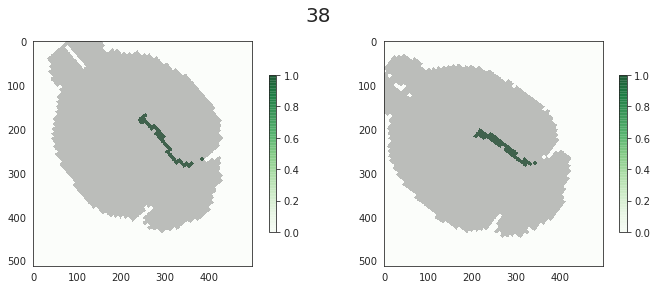

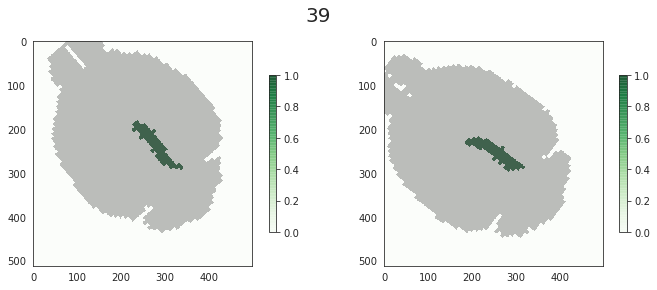

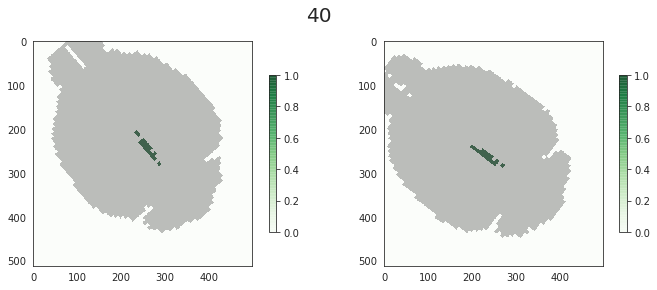

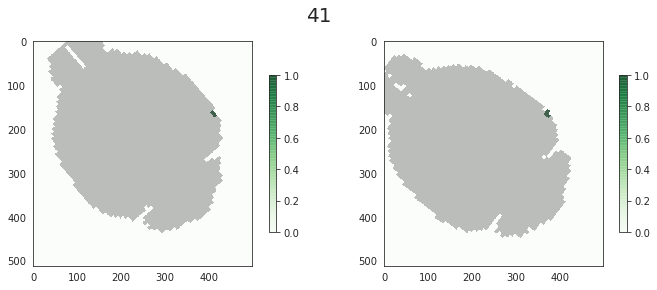

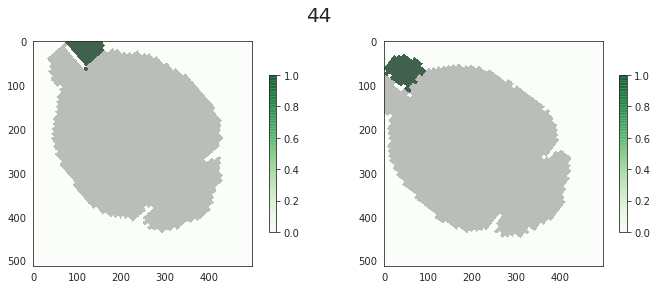

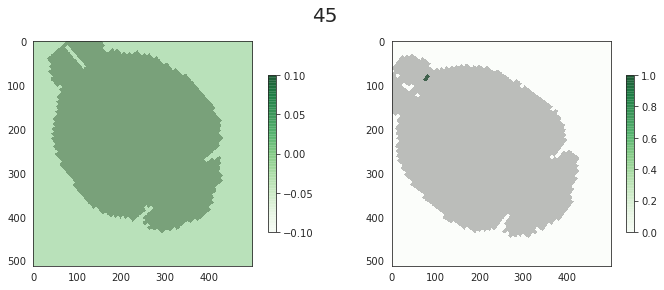

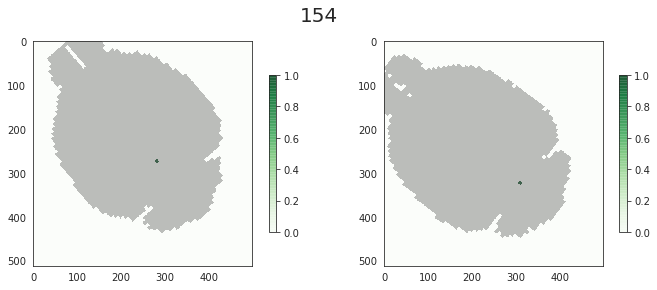

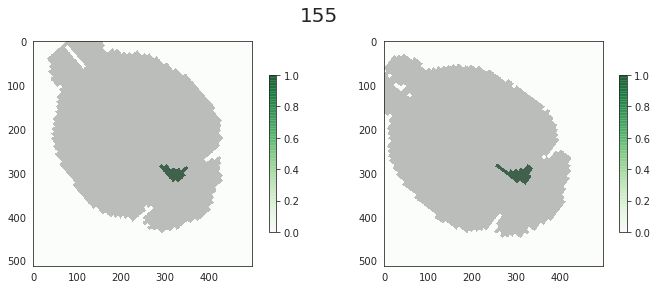

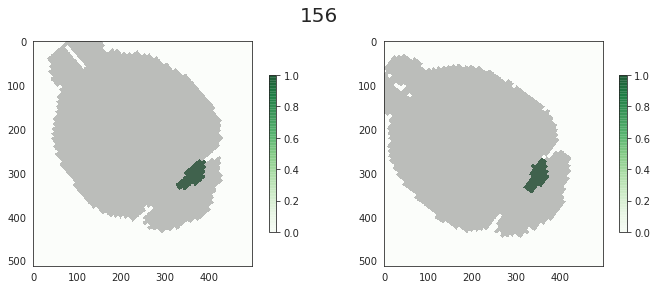

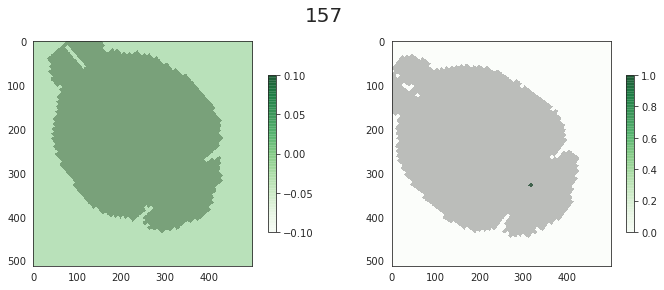

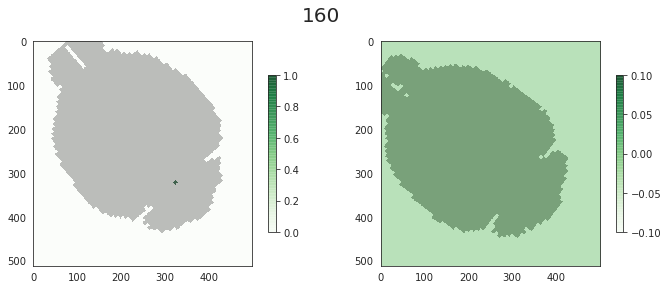

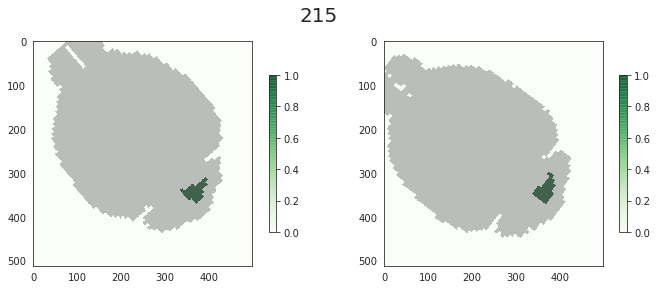

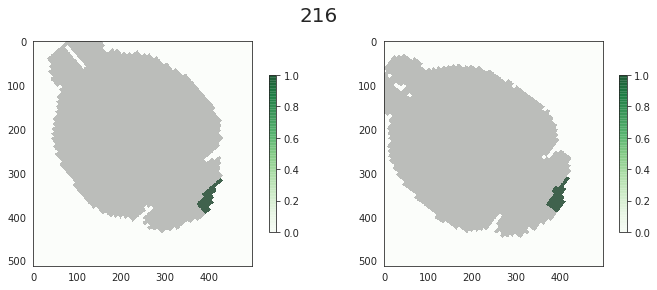

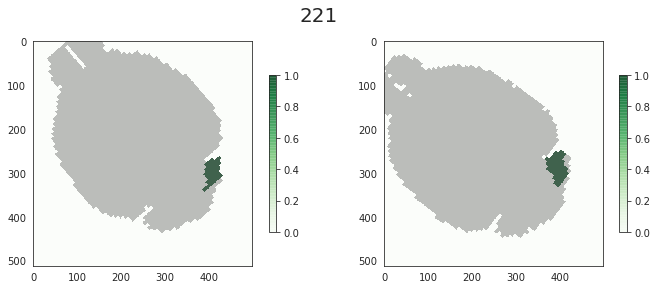

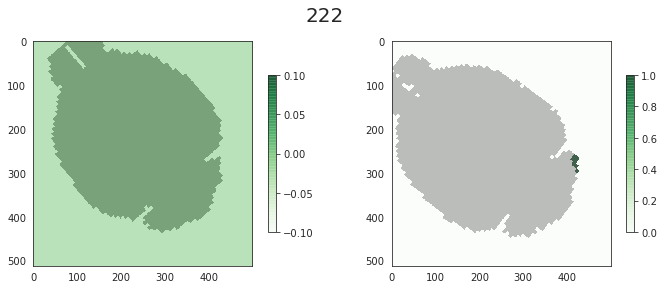

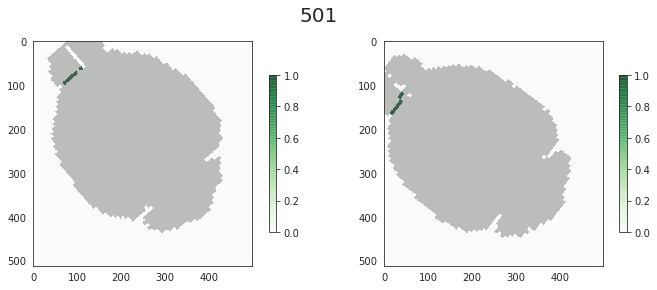

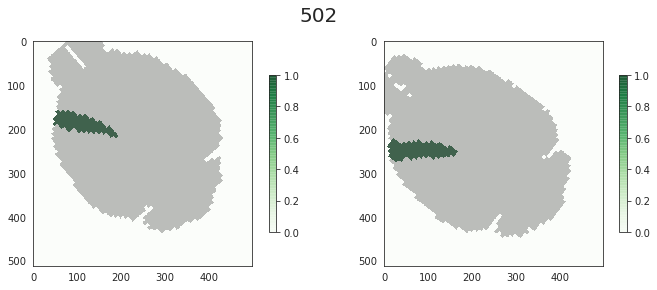

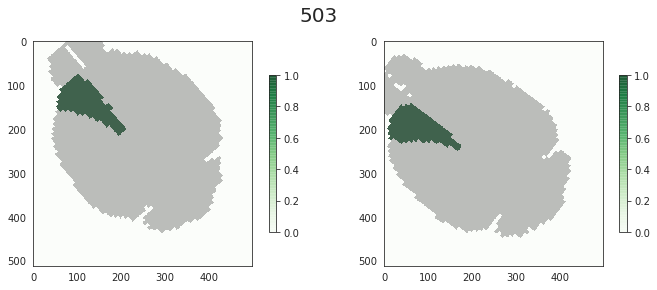

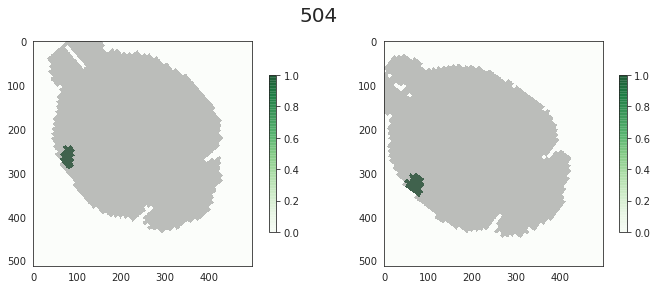

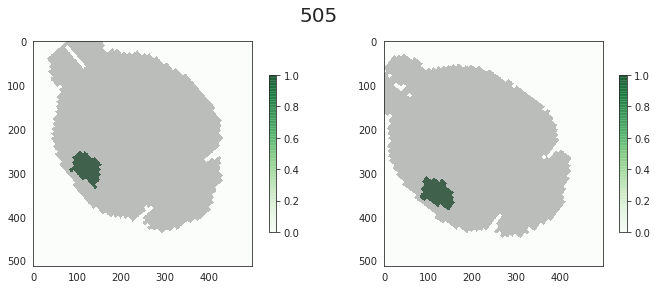

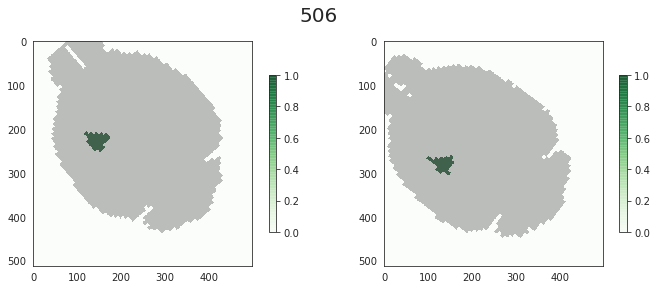

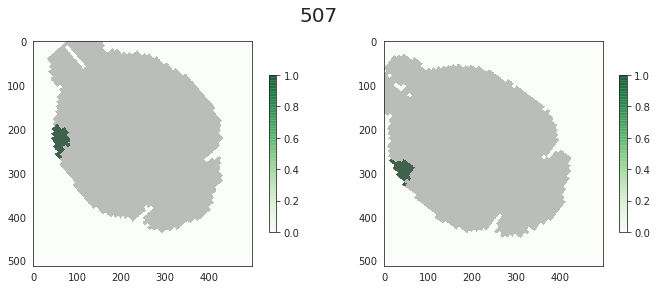

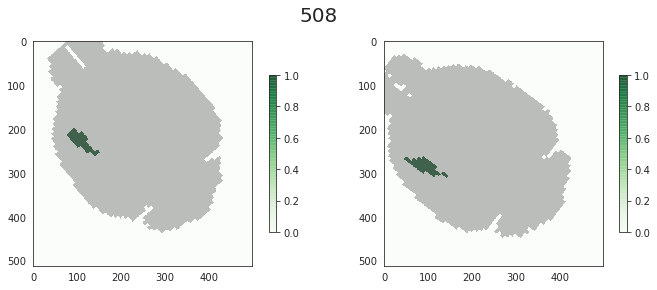

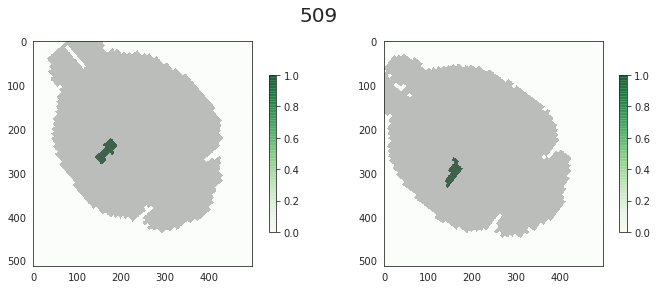

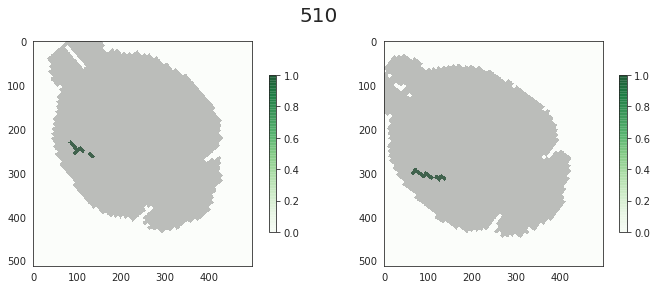

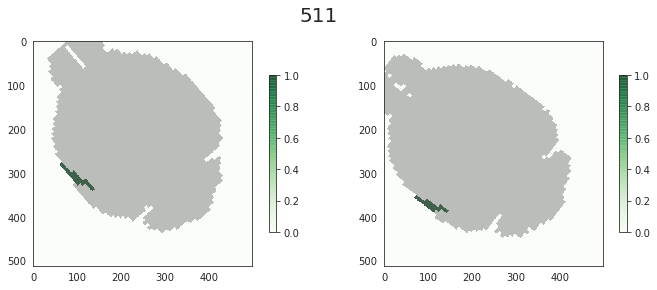

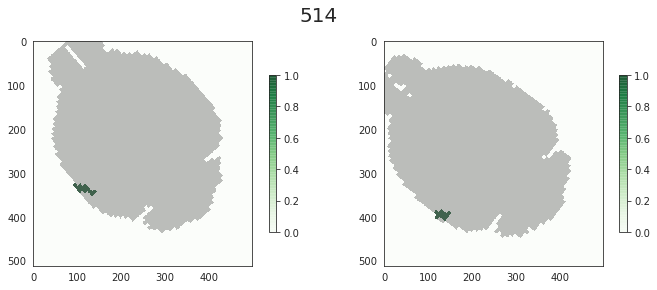

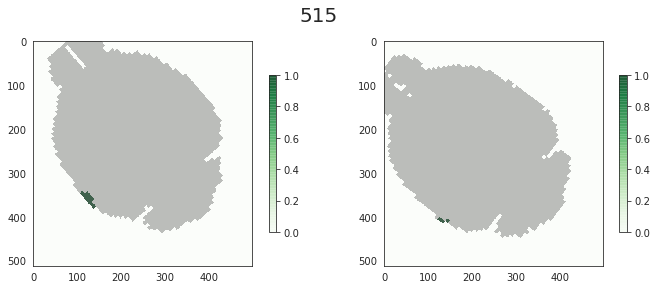

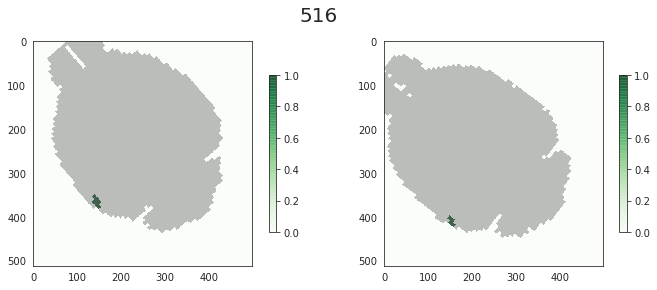

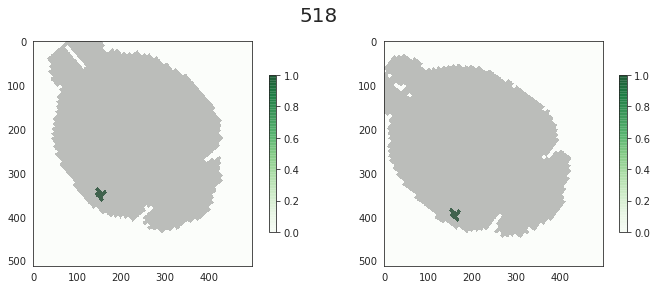

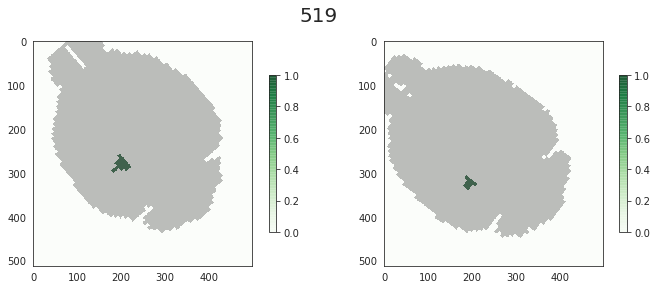

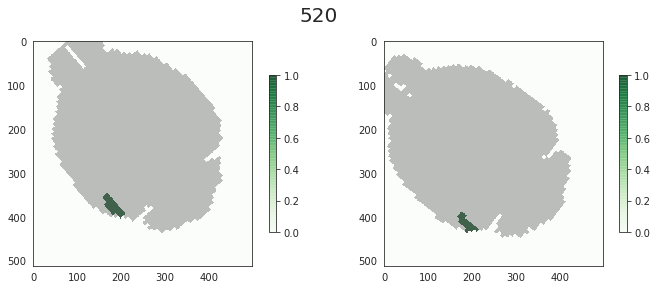

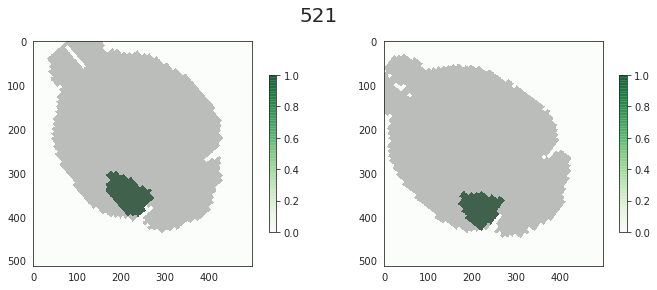

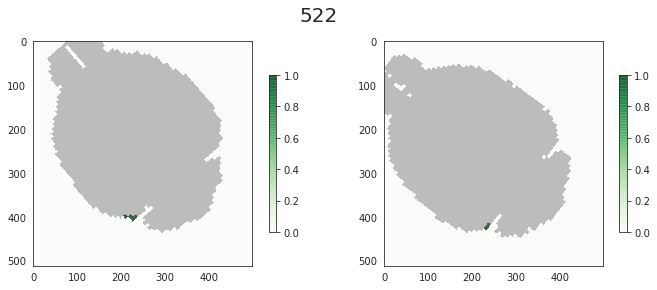

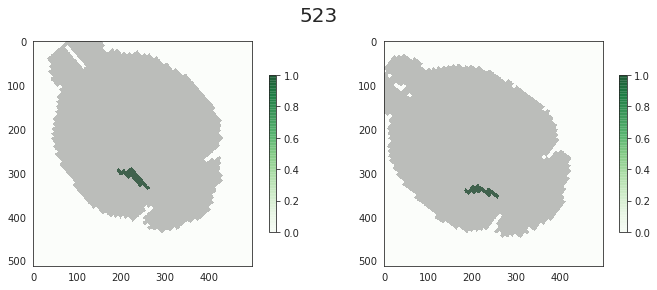

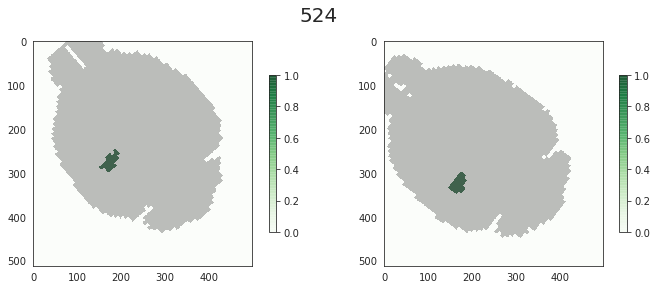

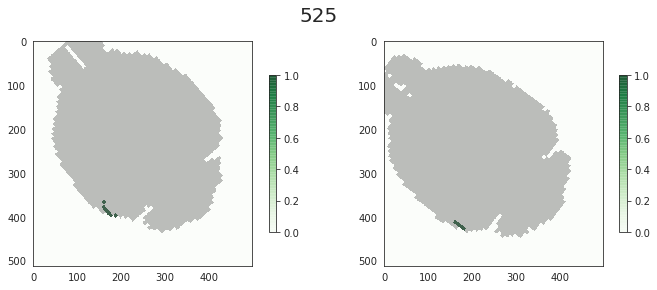

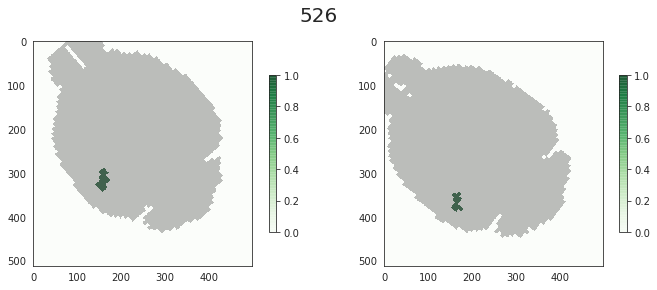

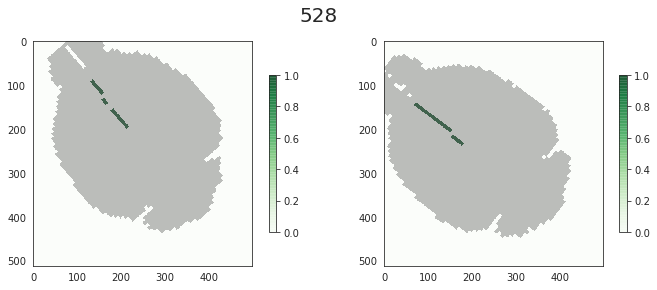

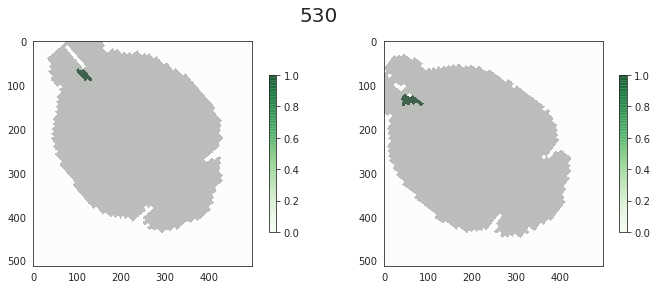

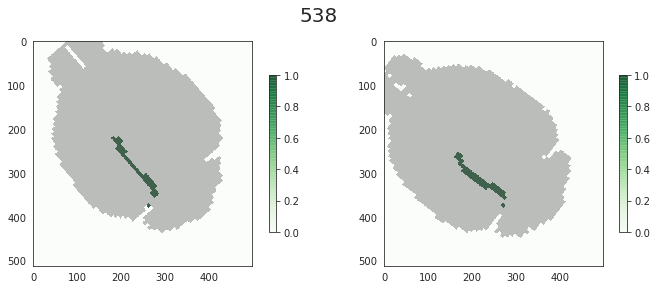

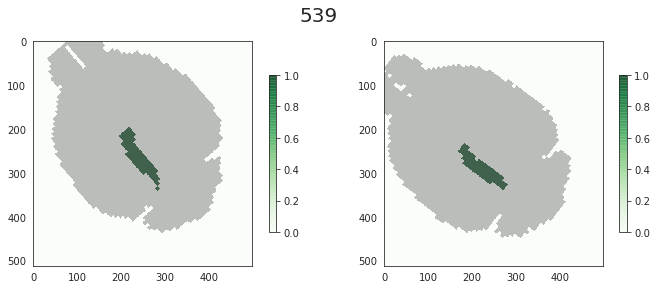

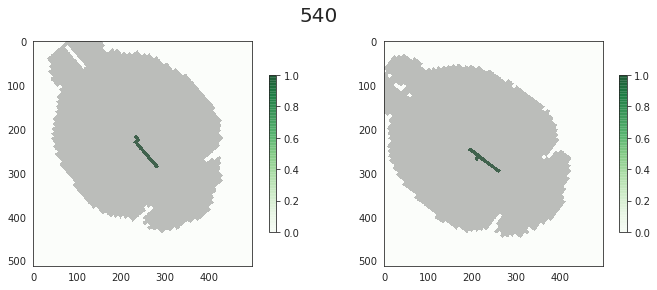

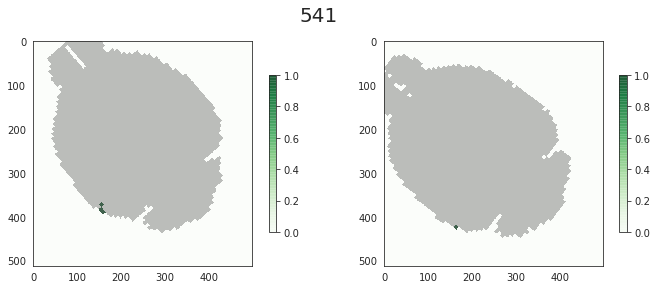

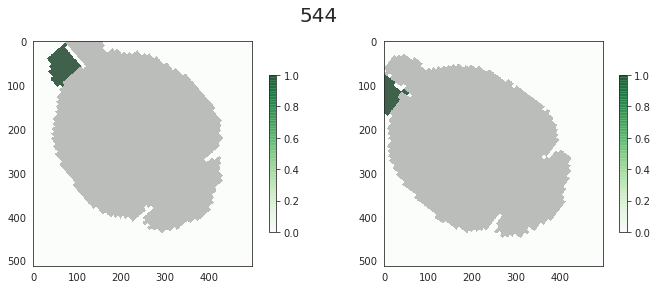

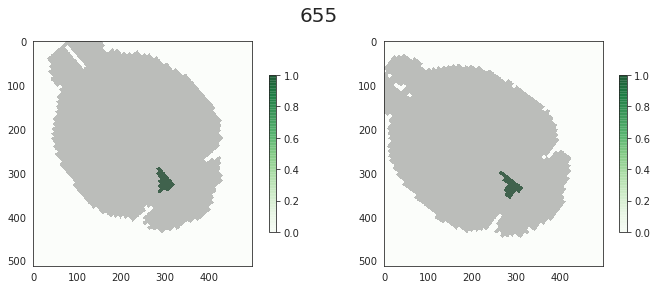

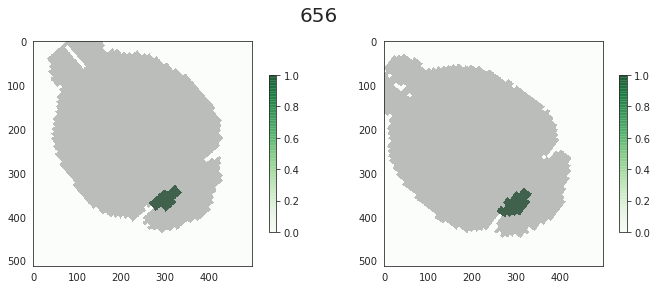

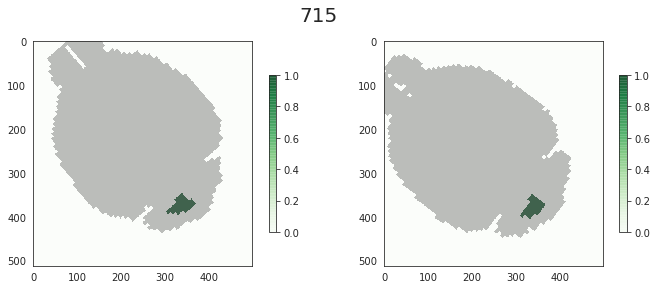

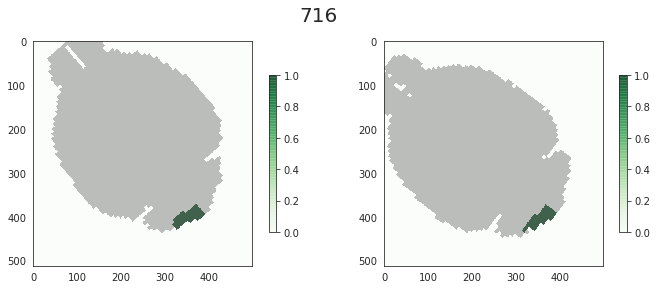

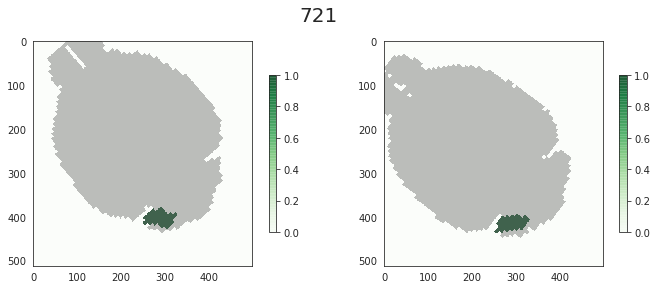

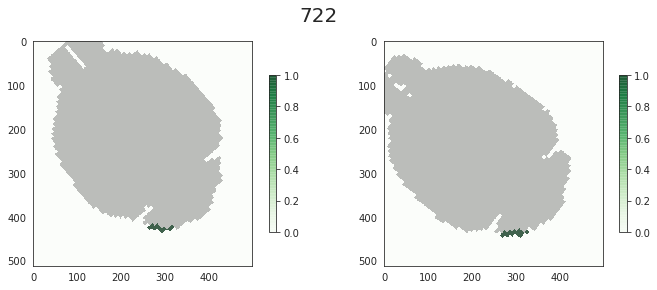

In [43]:
for i in sorted(set(np.unique(a1)).union(np.unique(a2))):
    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.imshow(a1[..., 0]==0, cmap='Greys_r', interpolation='none', alpha=0.5)
    plt.imshow(c1==i, cmap='Greens', interpolation='none', alpha=0.5)
    plt.colorbar(shrink=0.7)

    plt.subplot(122)
    plt.imshow(a2[..., 0]==0, cmap='Greys_r', interpolation='none', alpha=0.5)
    plt.imshow(c2==i, cmap='Greens', interpolation='none', alpha=0.5)
    plt.colorbar(shrink=0.7)

    plt.suptitle(int(i), fontsize=20)
    
    plt.tight_layout()
    plt.show()

In [46]:
len(np.unique(a1)), len(np.unique(a2)), len(set(np.unique(a1)).intersection(np.unique(a2)))

(74, 76, 72)

In [8]:
b = a.copy()
# b[b==0] = np.nan

for i, j in enumerate(np.unique(a)):
    b[b==j] = i

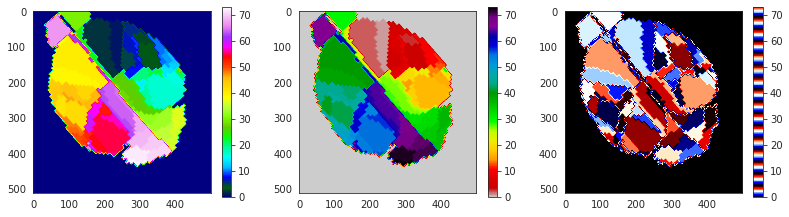

In [9]:
plt.figure(figsize=(13.5, 5))

plt.subplot(131)
plt.imshow(b[..., 0], cmap='gist_ncar')
plt.colorbar(shrink=0.7)

plt.subplot(132)
plt.imshow(b[..., 0], cmap='nipy_spectral_r')
plt.colorbar(shrink=0.7)

plt.subplot(133)
plt.imshow(b[..., 0], cmap='flag_r')
plt.colorbar(shrink=0.7)

In [10]:
np.unique(b)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73.])

In [11]:
from utils.processing import filter_boundaries

c = filter_boundaries(b, dim=2).squeeze()
c[c==0] = -1

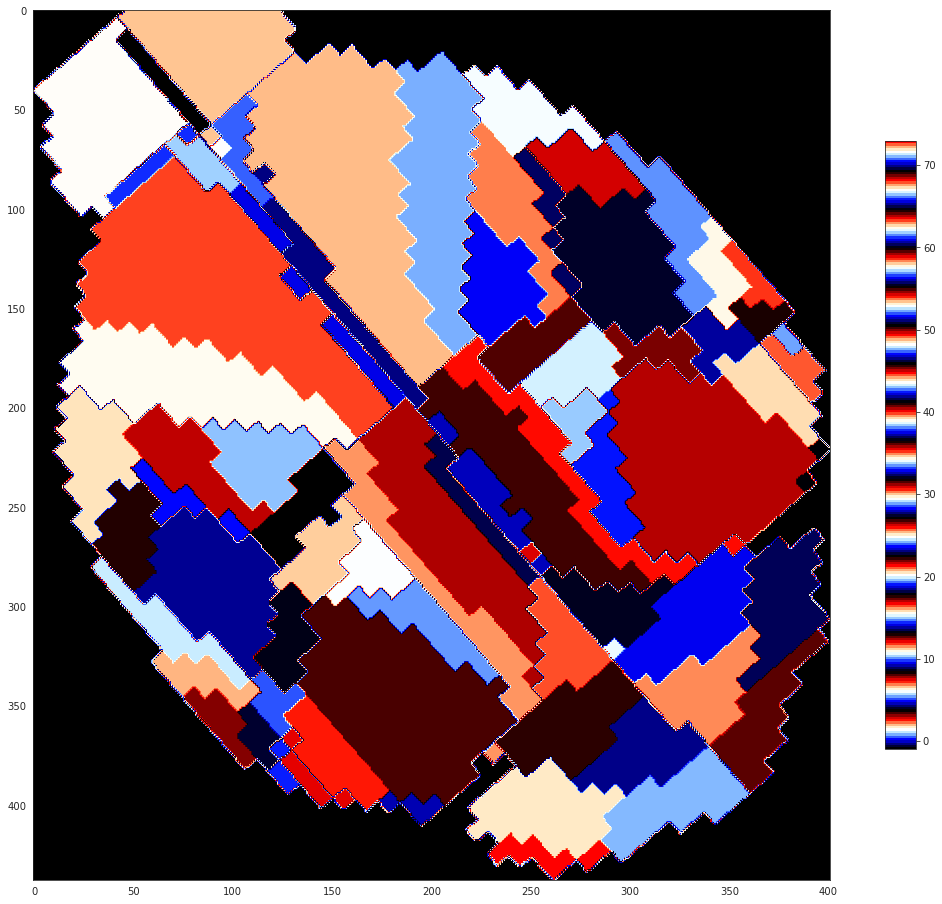

In [12]:
plt.figure(figsize=(20, 16))
plt.imshow(c, cmap='flag_r')
plt.colorbar(shrink=0.7)

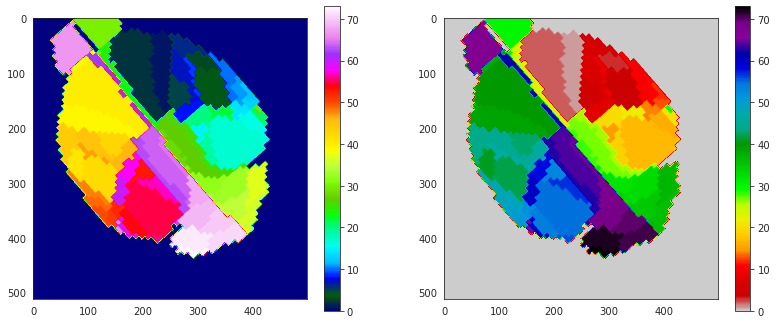

In [13]:
plt.figure(figsize=(13.5, 8))

plt.subplot(121)
plt.imshow(b[..., 0], cmap='gist_ncar')
plt.colorbar(shrink=0.7)

plt.subplot(122)
plt.imshow(b[..., 0], cmap='nipy_spectral_r')
plt.colorbar(shrink=0.7)

In [14]:
h = img.header

<OrthoSlicer3D: /home/hadi/Downloads/sub-SLC06_ses-1_space-individual_desc-fineatlas2d_ca2.nii.gz (512, 500, 1)>

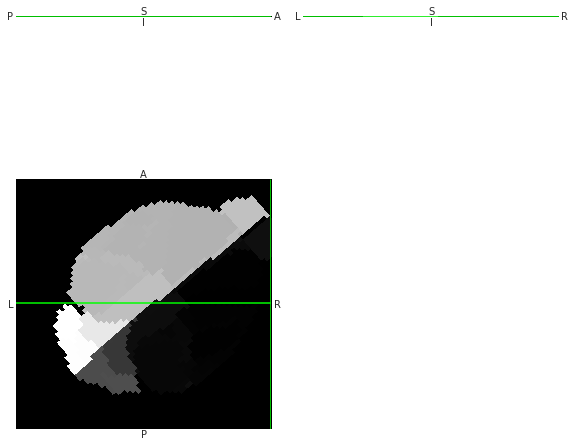

In [15]:
img.orthoview()

In [16]:
print(h)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 500   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.    0.025 0.025 0.025 1.    1.    1.    1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 724
glmin           : 0
descrip         : b''
aux_file        : b'none'
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [-0.025 

In [17]:
load_dir = '/home/hadi/Downloads'
file_name = 'sub-SLC06_ses-2_space-individual_desc-fineatlas2d_ca2.nii.gz'

In [18]:
img = nib.load(pjoin(load_dir, file_name))

In [19]:
a = img.get_fdata()
a.shape

(512, 500, 1)

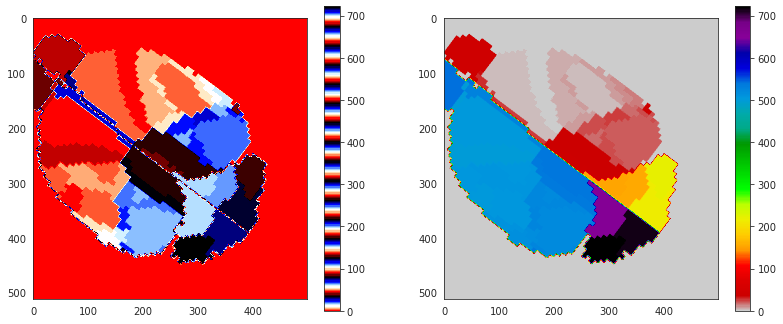

In [20]:
plt.figure(figsize=(13.5, 8))

plt.subplot(121)
plt.imshow(a[..., 0], cmap='flag')
plt.colorbar(shrink=0.7)

plt.subplot(122)
plt.imshow(a[..., 0], cmap='nipy_spectral_r')
plt.colorbar(shrink=0.7)

In [21]:
np.unique(a), len(np.unique(a))

(array([  0.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         14.,  15.,  16.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,
         26.,  28.,  30.,  34.,  38.,  39.,  40.,  41.,  44.,  45., 154.,
        155., 156., 157., 215., 216., 221., 222., 501., 502., 503., 504.,
        505., 506., 507., 508., 509., 510., 511., 514., 515., 516., 518.,
        519., 520., 521., 522., 523., 524., 525., 526., 528., 530., 538.,
        539., 540., 541., 544., 655., 656., 715., 716., 721., 722.]),
 76)

In [22]:
b = a.copy()
# b[b==0] = np.nan

for i, j in enumerate(np.unique(a)):
    b[b==j] = i

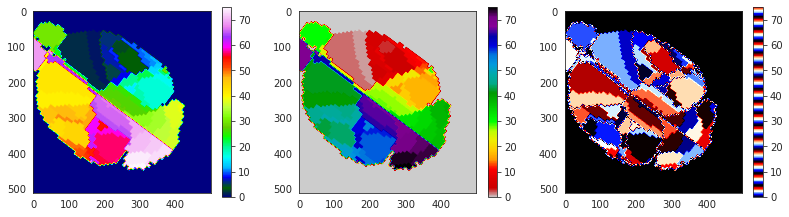

In [23]:
plt.figure(figsize=(13.5, 5))

plt.subplot(131)
plt.imshow(b[..., 0], cmap='gist_ncar')
plt.colorbar(shrink=0.7)

plt.subplot(132)
plt.imshow(b[..., 0], cmap='nipy_spectral_r')
plt.colorbar(shrink=0.7)

plt.subplot(133)
plt.imshow(b[..., 0], cmap='flag_r')
plt.colorbar(shrink=0.7)

In [24]:
np.unique(b)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75.])

In [25]:
from utils.processing import filter_boundaries

c = filter_boundaries(b, dim=2).squeeze()
c[c==0] = -1

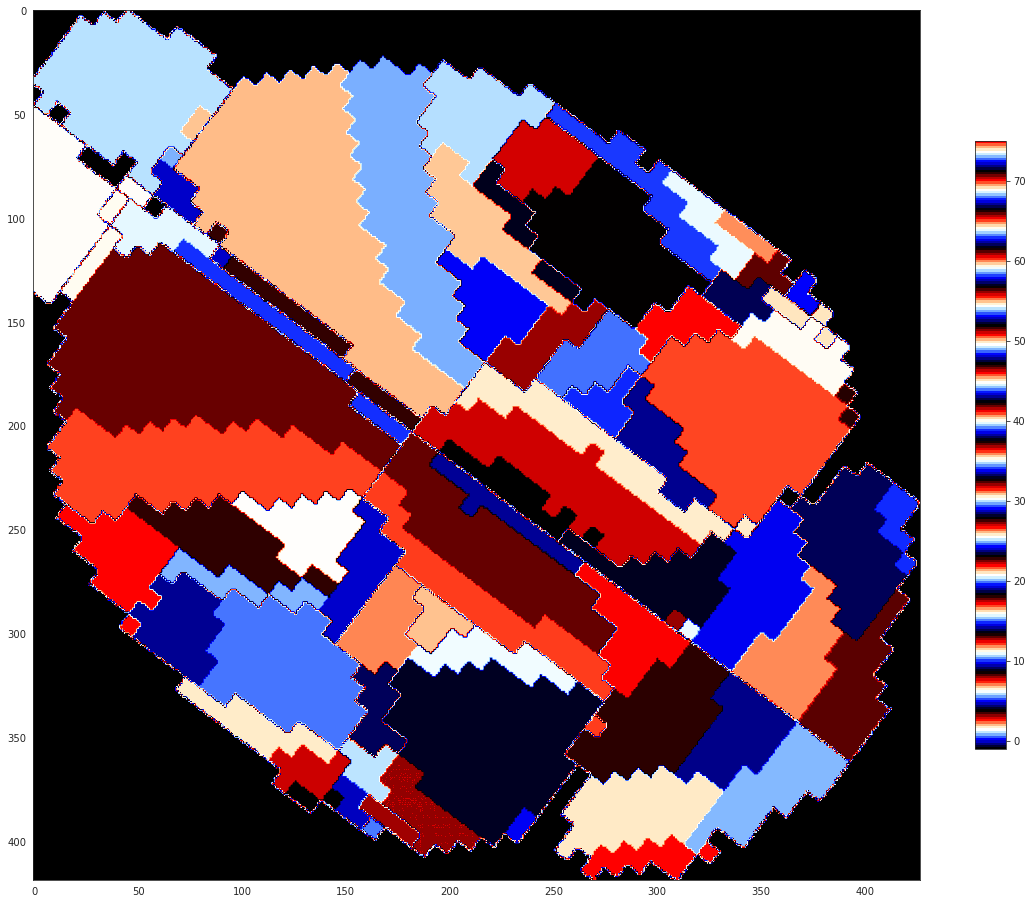

In [26]:
plt.figure(figsize=(20, 16))
plt.imshow(c, cmap='flag_r')
plt.colorbar(shrink=0.7)

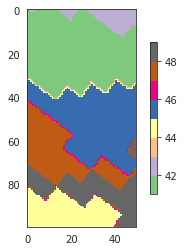

In [44]:
plt.figure(figsize=(5, 4))
plt.imshow(c[200:300, 100:150], cmap='Accent')
plt.colorbar(shrink=0.7)

In [145]:
from utils.processing import filter_boundaries

c = filter_boundaries(b, dim=2).squeeze()

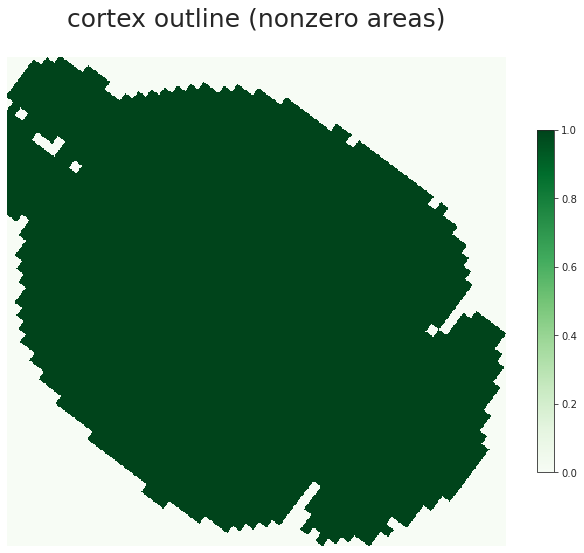

In [167]:
plt.figure(figsize=(11.2, 9))
plt.imshow(c>0, cmap='Greens', interpolation='none')
plt.axis('off')
plt.colorbar(shrink=0.7)
plt.title('cortex outline (nonzero areas)', fontsize=25, y=1.05)
plt.savefig('outline.pdf', dpi=100)
plt.show()

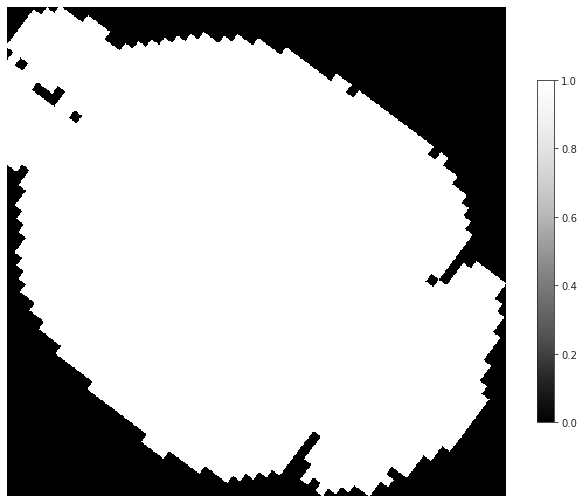

In [158]:
plt.figure(figsize=(11.2, 9))
lower = 0
higher = 1000
plt.imshow(np.logical_and(lower<c, c<higher), cmap='Greys_r',interpolation='none')
plt.axis('off')
plt.colorbar(shrink=0.7)

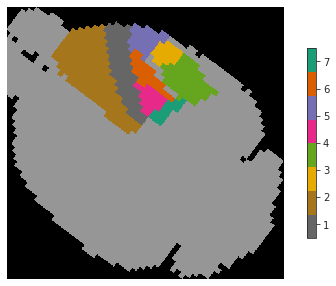

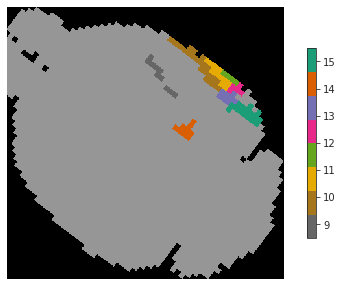

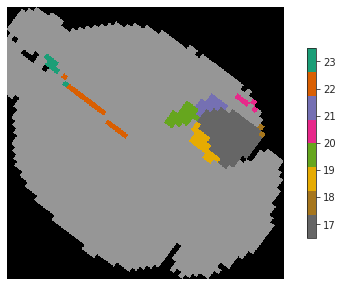

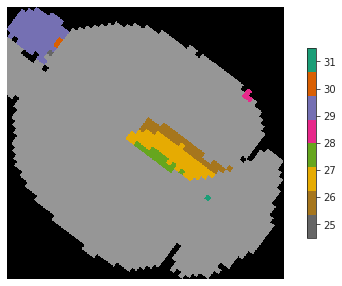

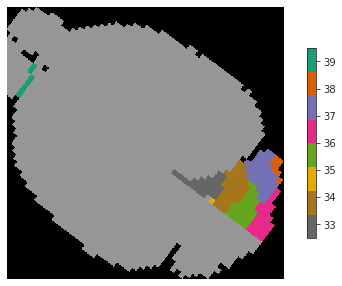

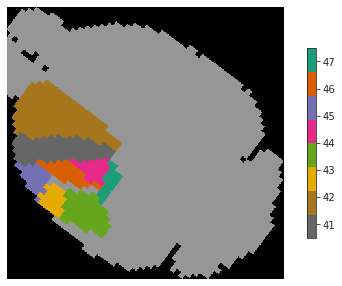

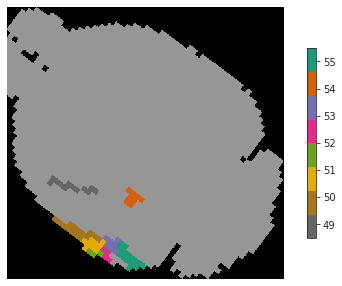

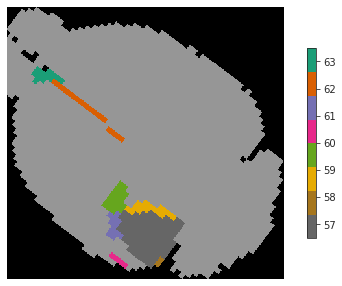

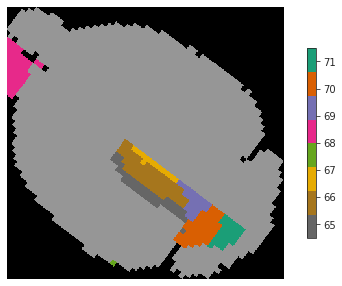

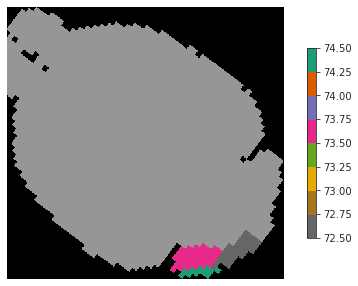

In [168]:
for i in range(int(np.ceil(len(np.unique(c)) / 8))):
    d = c.copy()
    d[d>(i+1)*8] = np.nan
    d[d<i*8+1] = np.nan
    d[c==0] = np.nan

    plt.figure(figsize=(8, 5))
    plt.imshow(c>0, cmap='Greys_r', vmin=0.5, vmax=1.5, interpolation='none')
    plt.imshow(d-0.5, cmap='Dark2_r', interpolation='none')
    plt.axis('off')
    plt.colorbar(shrink=0.7)

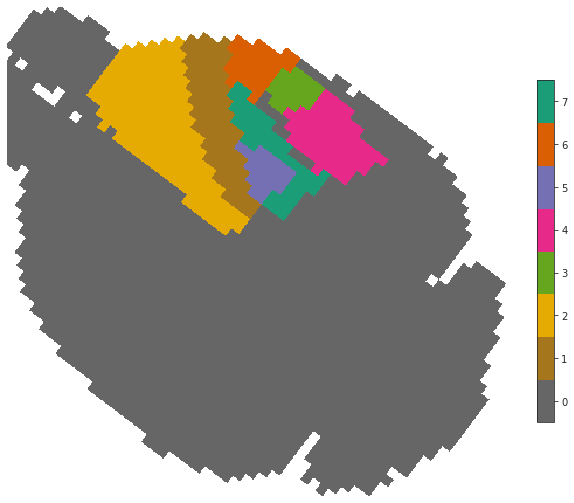

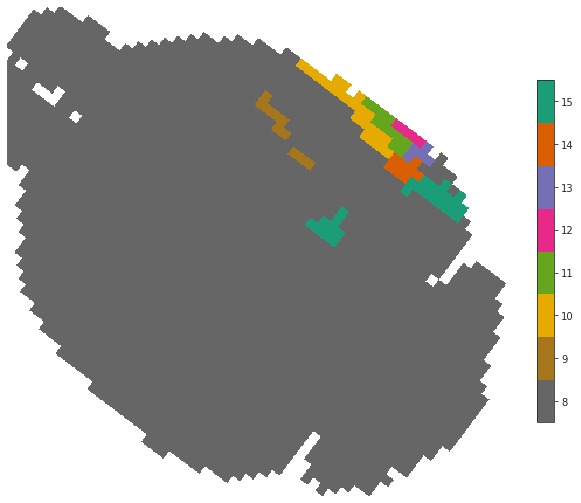

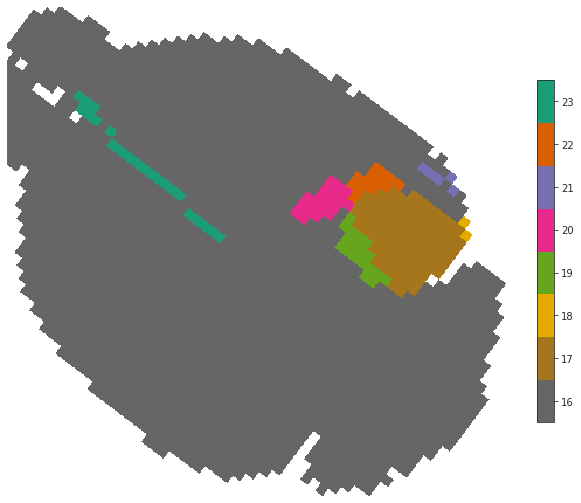

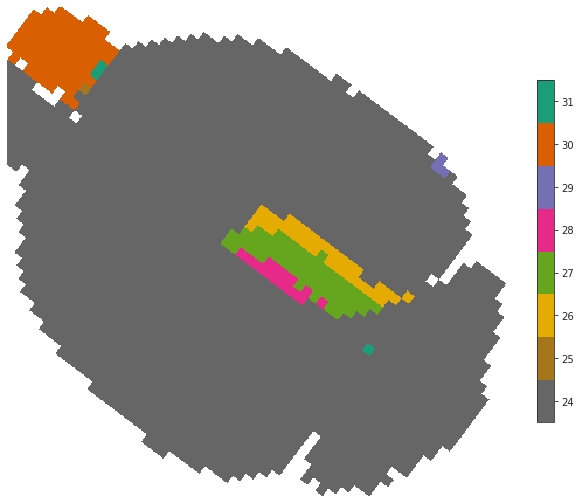

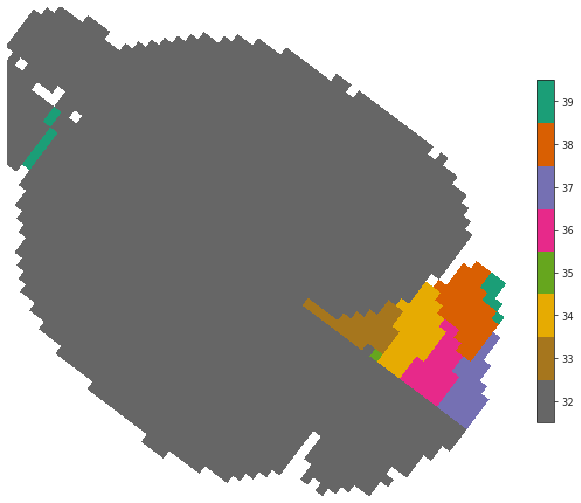

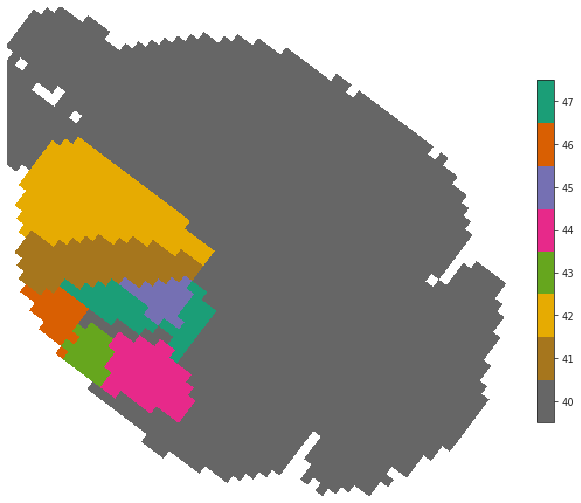

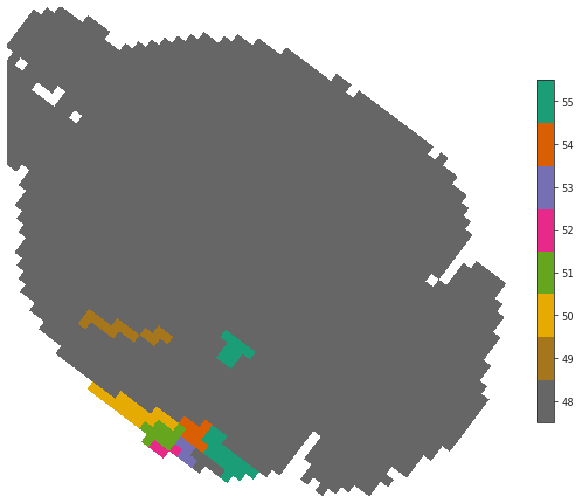

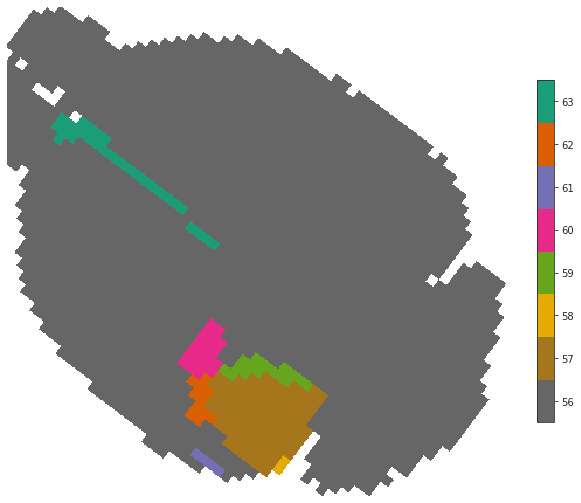

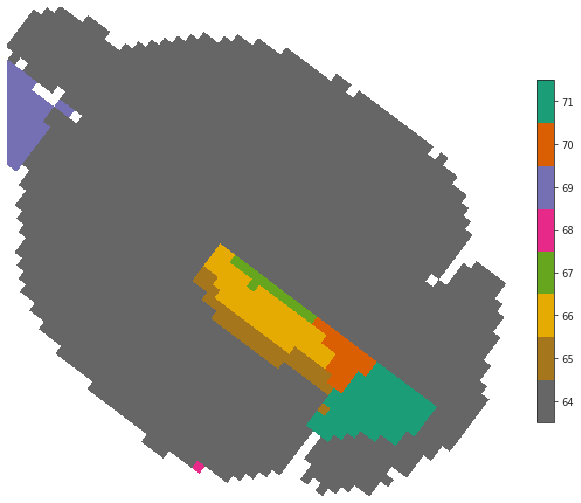

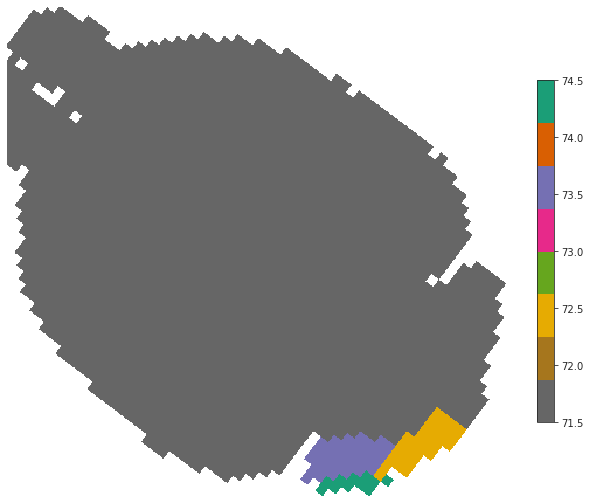

In [129]:
for i in range(int(np.ceil(len(np.unique(c)) / 8))):
    d = c.copy()
    d[d>(i+1)*8] = i*8
    d[d<i*8] = i*8
    d[c==0] = np.nan

    plt.figure(figsize=(11.2, 9))
    plt.imshow(d-0.5, cmap='Dark2_r', interpolation='none')
    plt.axis('off')
    plt.colorbar(shrink=0.7)

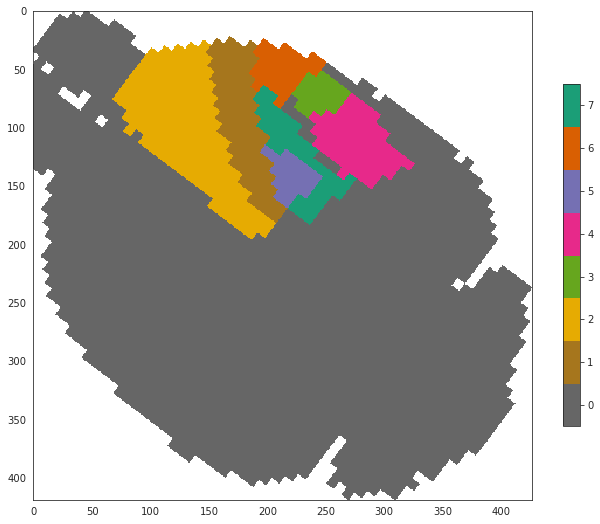

In [132]:
i = 0

d = c.copy()
d[d>(i+1)*8] = i*8
d[d<i*8] = i*8
d[c==0] = np.nan

plt.figure(figsize=(11.2, 9))
plt.imshow(d-0.5, cmap='Dark2_r', interpolation='none')
plt.colorbar(shrink=0.7)

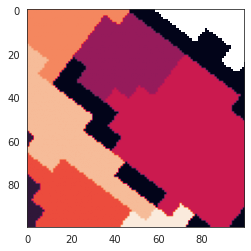

In [133]:
i = 0

d = c.copy()
d[d>(i+1)*8] = i*8
d[d<i*8] = i*8
d[c==0] = np.nan

plt.imshow(d[50:150, 200:300])

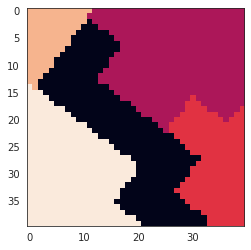

In [139]:

plt.imshow(d[70:110, 210:250])

In [141]:
d[70:110, 210:250][15]

array([7., 7., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3.])